In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import os


In [24]:
# Load crime dataset
df = pd.read_csv('data/crime/crime_aggregated.csv')

# Load population data
df_pop = pd.read_csv('data/pop/pop_aggregated.csv')

In [25]:
# ============================================================================
# STEP 1: PREPROCESSING - Load, Rename, Clean, Merge
# ============================================================================

# 1.1 Load raw data
df_crime_raw = pd.read_csv('data/crime/crime_aggregated.csv')
df_pop_raw = pd.read_csv('data/pop/pop_aggregated.csv')

# 1.2 Rename columns IMMEDIATELY to avoid conflicts
# Raw columns: date, state, state_code, crime, count, Clearances
# 'crime' = crime TYPE (categorical), 'count' = actual count number
df_crime = df_crime_raw.rename(columns={
    'crime': 'crime_type',
    'count': 'crime_count'
})

# 1.3 Convert data types
df_crime['date'] = pd.to_datetime(df_crime['date'], format='%Y/%m')
df_crime['crime_count'] = pd.to_numeric(df_crime['crime_count'], errors='coerce')
df_crime = df_crime.sort_values('date').reset_index(drop=True)

df_pop_raw['date'] = pd.to_datetime(df_pop_raw['date'], format='%Y/%m')
df_pop_raw['population'] = pd.to_numeric(df_pop_raw['population'], errors='coerce')

# 1.4 Trim dates - remove last incomplete period
last_date = df_crime['date'].iloc[-1]
df_crime = df_crime[df_crime['date'] != last_date].reset_index(drop=True)

# 1.5 Merge population data
# Add year for merging (population is yearly, crime is monthly)
df_pop_raw['year'] = df_pop_raw['date'].dt.year
df_crime['year'] = df_crime['date'].dt.year

# Merge crime with population on year and state_code
df_merged = df_crime.merge(
    df_pop_raw[['year', 'state_code', 'population']], 
    on=['year', 'state_code'], 
    how='left'
)

# Handle 2025 data: use 2024 population
pop_2024 = df_pop_raw[df_pop_raw['year'] == 2024][['state_code', 'population']].copy()
pop_2024.columns = ['state_code', 'pop_2024']
df_merged = df_merged.merge(pop_2024, on='state_code', how='left')
df_merged['population'] = df_merged['population'].fillna(df_merged['pop_2024'])
df_merged = df_merged.drop(columns=['pop_2024'])

# 1.6 Keep only necessary columns from preprocessing
df_clean = df_merged[['date', 'state', 'state_code', 'crime_type', 'crime_count', 
                       'Clearances', 'year', 'population']].copy()

print("✓ PREPROCESSING COMPLETE")
print(f"  Shape: {df_clean.shape}")
print(f"  Columns: {list(df_clean.columns)}")
print(f"  Date range: {df_clean['date'].min()} to {df_clean['date'].max()}")

# ============================================================================
# STEP 2: CREATE BENCHMARKS - Aggregates and Derived Metrics
# ============================================================================

# 2.1 Calculate total population and crime at each date
total_pop_at_date = df_clean.groupby('date', as_index=False)['population'].sum()
total_pop_at_date.columns = ['date', 'total_population_at_date']

total_crime_at_date = df_clean.groupby('date', as_index=False)['crime_count'].sum()
total_crime_at_date.columns = ['date', 'total_crime_count_at_date']

# Merge aggregates into main dataframe
df_final = df_clean.copy()
df_final = df_final.merge(total_pop_at_date, on='date', how='left')
df_final = df_final.merge(total_crime_at_date, on='date', how='left')

# 2.2 Calculate derived metrics
# Crime rate per 100k population
df_final['crime_rate'] = (df_final['crime_count'] / df_final['population']) * 100000

# Standardized crime count (Z-score standardization)
df_final['crime_count_standardized'] = (df_final['crime_count'] - df_final['crime_count'].mean()) / df_final['crime_count'].std()

# Population-weighted crime
df_final['crime_count_weighted'] = (df_final['population'] / df_final['total_population_at_date']) * df_final['crime_count']

# Crime relative intensity (state rate / national rate)
national_rate = df_final['total_crime_count_at_date'] / df_final['total_population_at_date']
state_rate = df_final['crime_count'] / df_final['population']
df_final['crime_relative_intensity'] = state_rate / national_rate

# 2.3 Create normalized values (0-1 scale) for key metrics
df_final['crime_rate_normalized'] = (
    (df_final['crime_rate'] - df_final['crime_rate'].min()) / 
    (df_final['crime_rate'].max() - df_final['crime_rate'].min())
)

df_final['crime_count_normalized'] = (
    (df_final['crime_count'] - df_final['crime_count'].min()) / 
    (df_final['crime_count'].max() - df_final['crime_count'].min())
)

# Final cleanup
df_final = df_final.sort_values(['date', 'state_code']).reset_index(drop=True)

print("\n✓ BENCHMARKS CREATED")
print(f"  Final shape: {df_final.shape}")
print(f"  Final columns: {list(df_final.columns)}")
print(f"\nColumn Summary:")
for col in df_final.columns:
    print(f"  - {col}: {df_final[col].dtype}")

# Assign to df_merged for compatibility with downstream code
df_merged = df_final


✓ PREPROCESSING COMPLETE
  Shape: (6840, 8)
  Columns: ['date', 'state', 'state_code', 'crime_type', 'crime_count', 'Clearances', 'year', 'population']
  Date range: 2015-10-01 00:00:00 to 2025-09-01 00:00:00

✓ BENCHMARKS CREATED
  Final shape: (6840, 16)
  Final columns: ['date', 'state', 'state_code', 'crime_type', 'crime_count', 'Clearances', 'year', 'population', 'total_population_at_date', 'total_crime_count_at_date', 'crime_rate', 'crime_count_standardized', 'crime_count_weighted', 'crime_relative_intensity', 'crime_rate_normalized', 'crime_count_normalized']

Column Summary:
  - date: datetime64[ns]
  - state: object
  - state_code: object
  - crime_type: object
  - crime_count: float64
  - Clearances: float64
  - year: int32
  - population: float64
  - total_population_at_date: float64
  - total_crime_count_at_date: float64
  - crime_rate: float64
  - crime_count_standardized: float64
  - crime_count_weighted: float64
  - crime_relative_intensity: float64
  - crime_rate_normal

In [ ]:
# Normalized columns already created in Step 2
# Available normalized metrics:
# - crime_rate_normalized
# - crime_count_normalized

print("Available benchmark columns:")
benchmark_cols = [col for col in df_merged.columns if 'crime' in col.lower()]
for col in benchmark_cols:
    print(f"  - {col}")


Available benchmark columns:
  - crime_type
  - crime_count
  - total_crime_count_at_date
  - crime_rate
  - crime_count_standardized
  - crime_count_weighted
  - crime_relative_intensity
  - crime_rate_normalized
  - crime_count_normalized


In [27]:
# ============================================================================
# STEP 3: PLOTTING FUNCTION - DRY Approach
# ============================================================================

def plot_crime_metric(df, column, title, ylabel, filename, window=3, figsize=(15, 10)):
    """
    Generate time series plot with moving average for a crime metric.
    
    Parameters:
    ----------
    df : DataFrame
        DataFrame with crime data (must have 'date' column and specified metric column)
    column : str
        Column name to plot
    title : str
        Plot title
    ylabel : str
        Y-axis label
    filename : str
        Output filename (without extension)
    window : int, default=3
        Moving average window size in months
    figsize : tuple, default=(15, 10)
        Figure size (width, height)
    
    Returns:
    -------
    None
        Saves plot to 'plot/{filename}_ma{window}.png' and displays it
    """
    # Calculate statistics for each time point
    stats = df.groupby('date')[column].agg(
        median='median',
        q25=lambda x: x.quantile(0.25),
        q75=lambda x: x.quantile(0.75)
    )
    
    # Apply a 3-month moving average
    stats_ma = stats.rolling(window=window).mean()
    
    # Plotting
    plt.figure(figsize=figsize)
    
    # Plot the median line
    plt.plot(stats_ma.index, stats_ma['median'], color='black', linestyle='-', label=f'Median (MA({window}))')
    
    # Plot the 25th and 75th percentile lines and fill the area
    plt.plot(stats_ma.index, stats_ma['q25'], color='gray', linestyle='--', label=f'25th Percentile (MA({window}))')
    plt.plot(stats_ma.index, stats_ma['q75'], color='gray', linestyle='--', label=f'75th Percentile (MA({window}))')
    plt.fill_between(stats_ma.index, stats_ma['q25'], stats_ma['q75'], color='gray', alpha=0.2)
    
    # Adjust the x label, start at 3rd point (MA(3) first valid), every 12th label, rotated 45 degrees
    plt.xticks(ticks=stats_ma.index[window::12], rotation=45, ha='right')
    
    plt.xlabel('Time (Date)')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    
    # Create plot directory if it doesn't exist and save the figure
    os.makedirs('plot', exist_ok=True)
    plt.savefig(f'plot/{filename}.png')
    
    plt.show()

print("✓ Plotting function defined")

✓ Plotting function defined


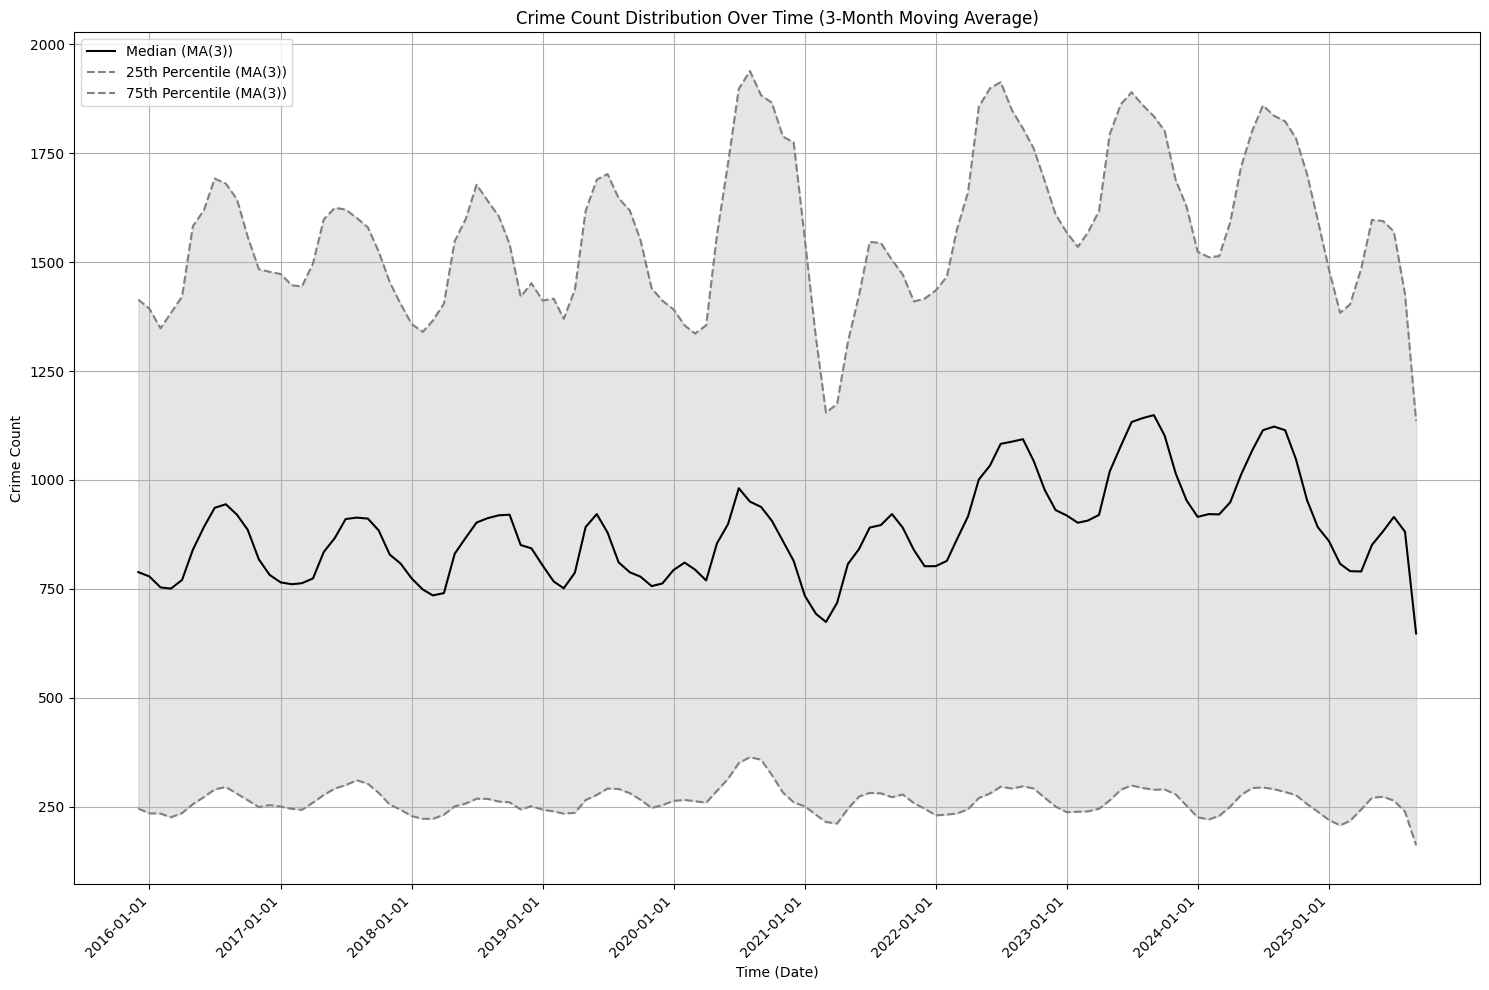

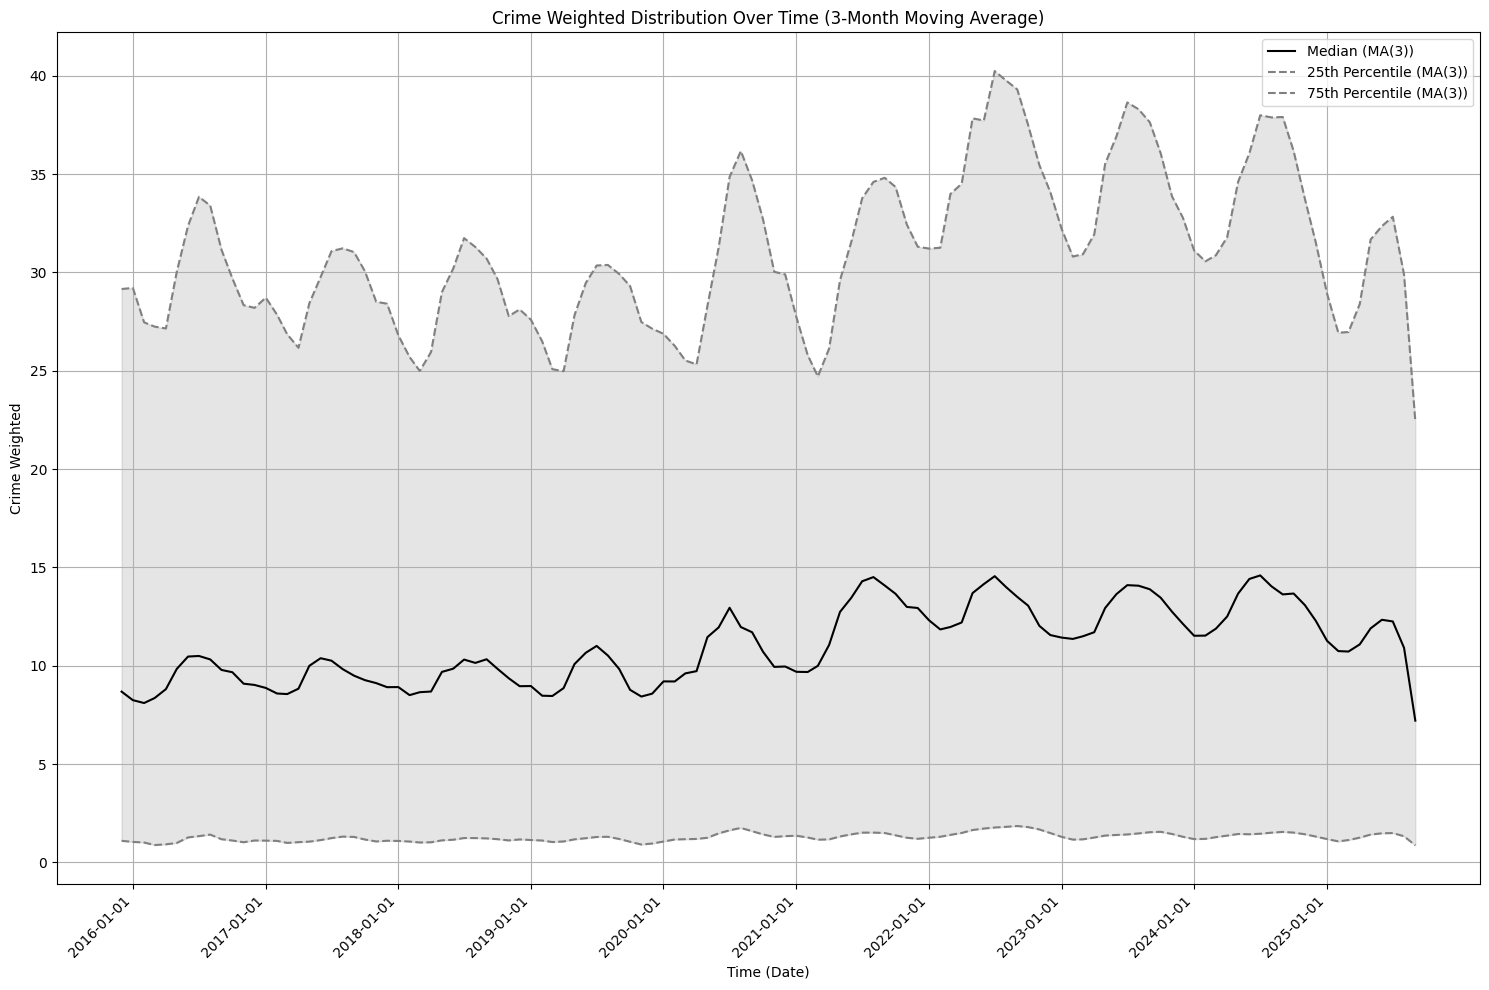

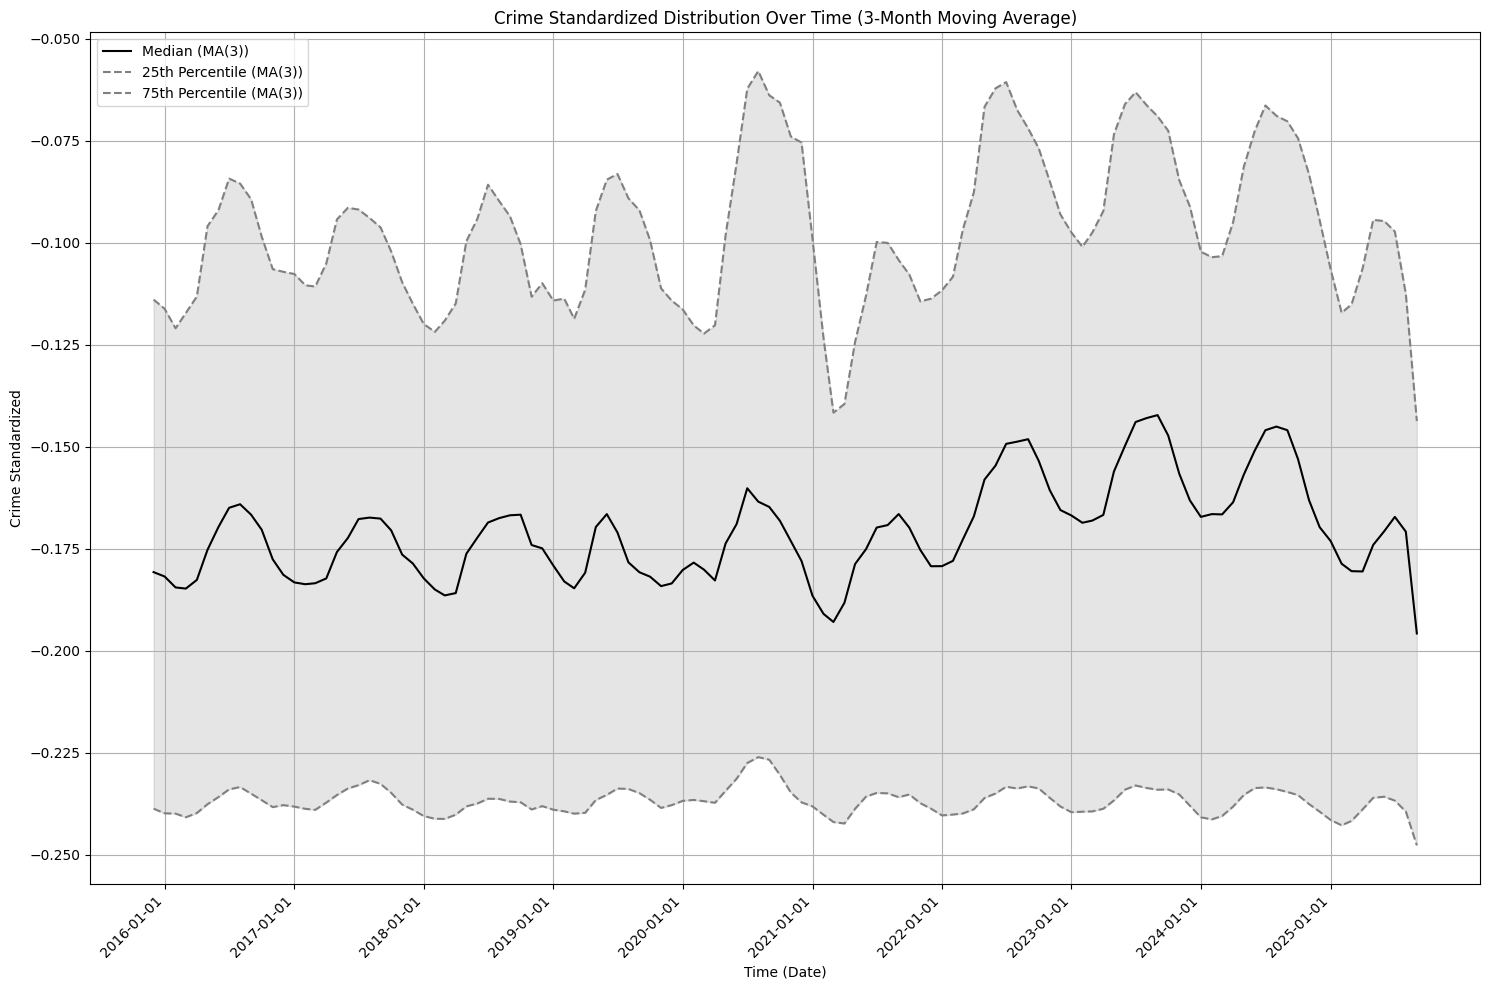

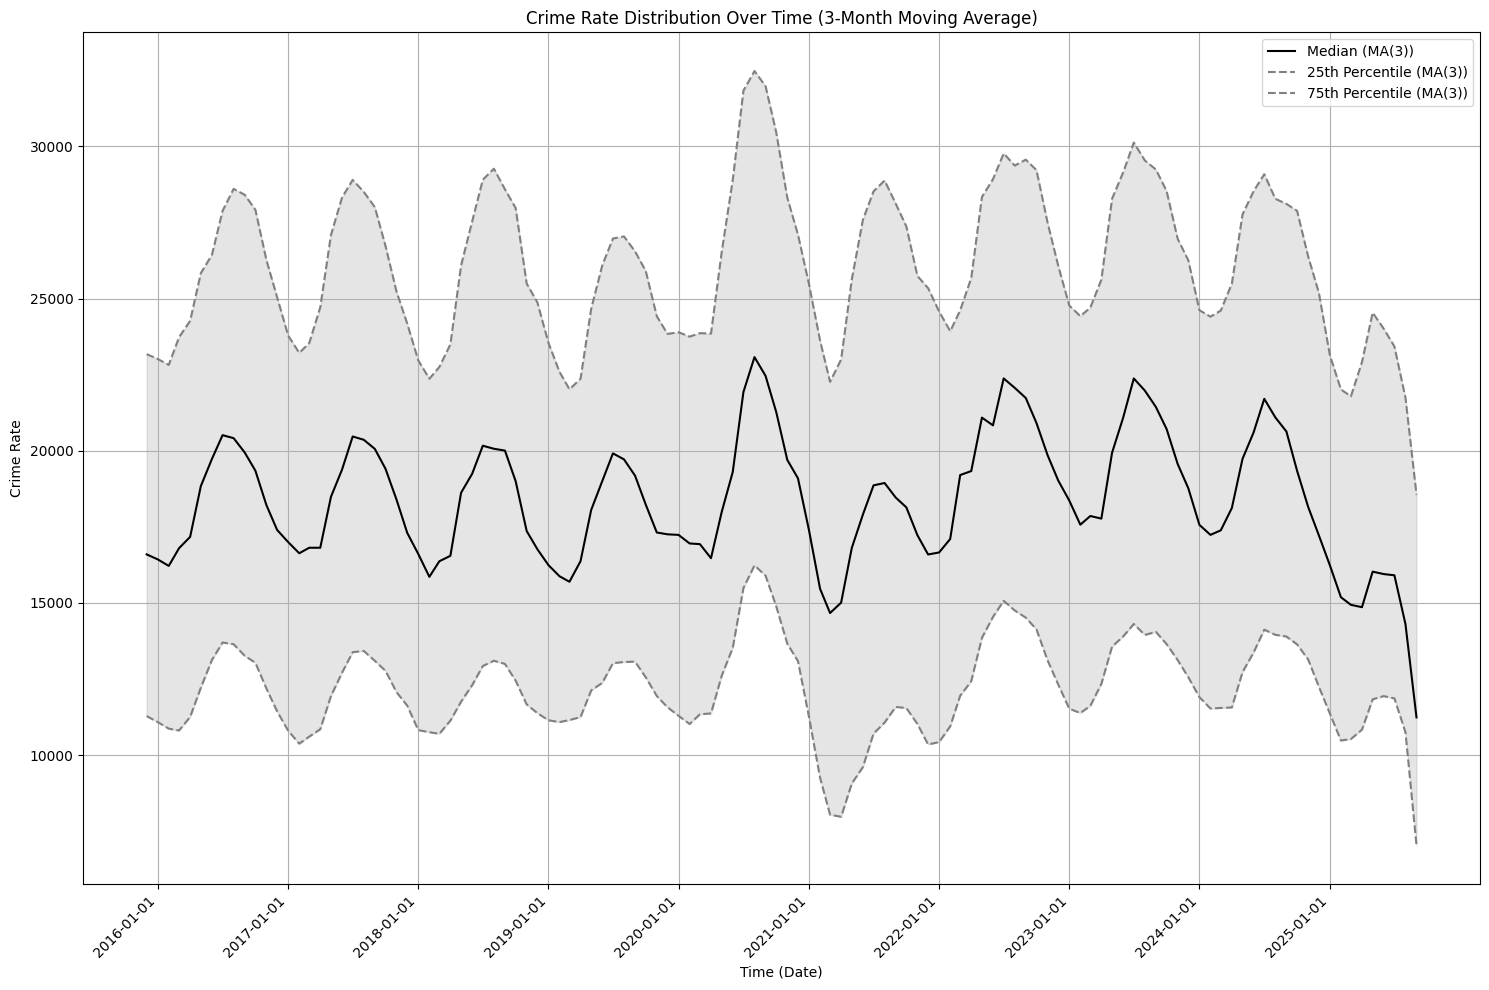

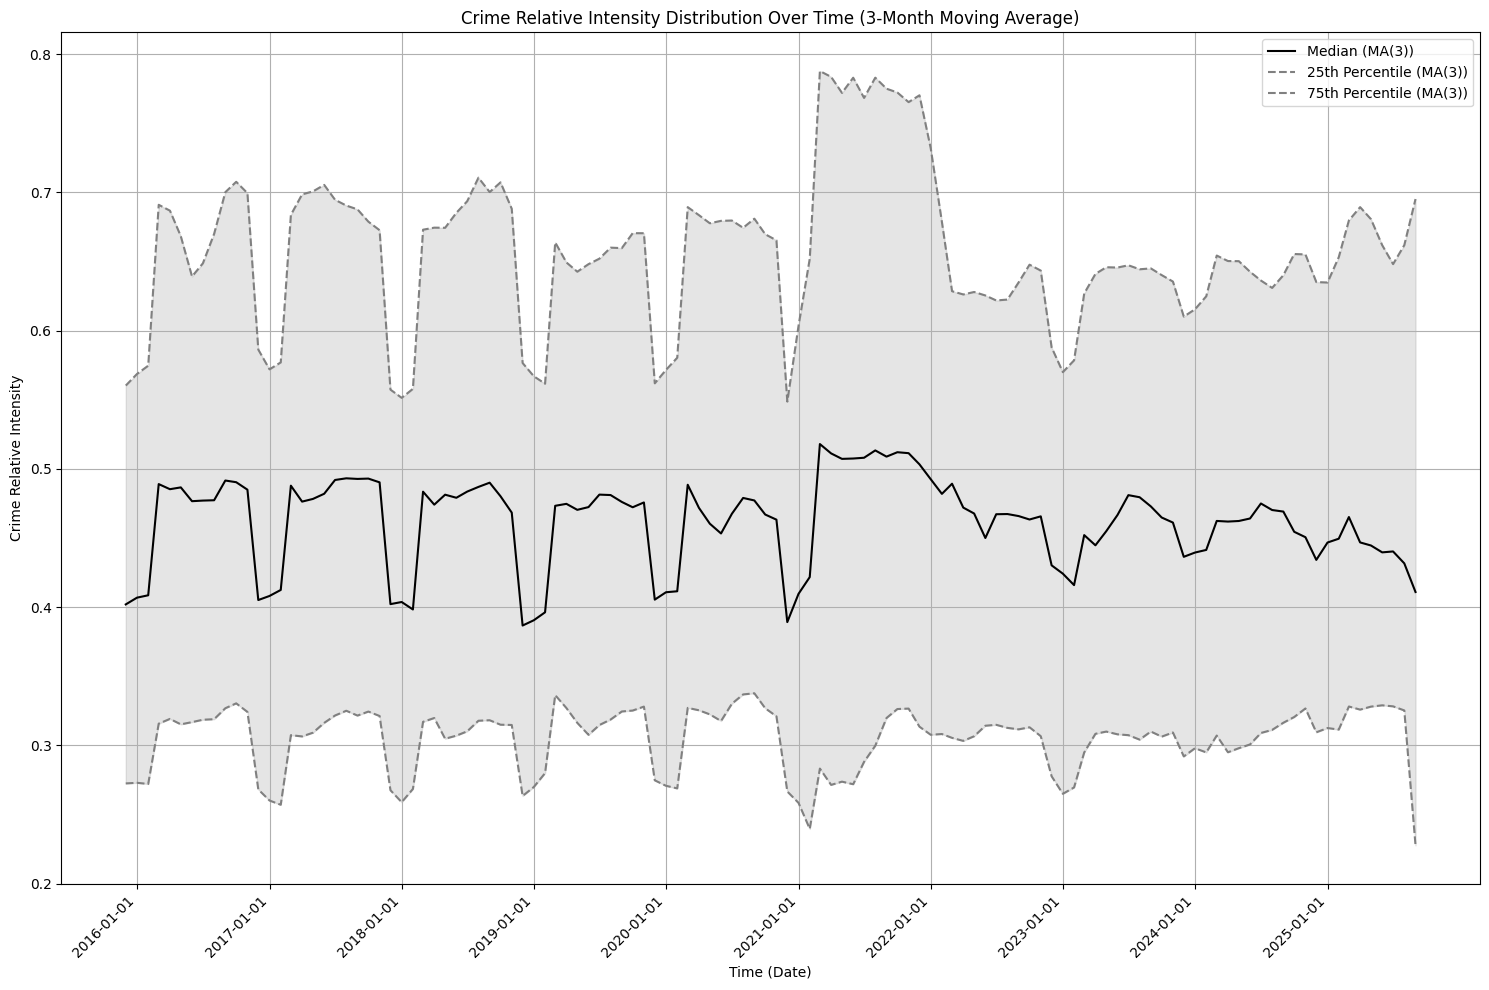

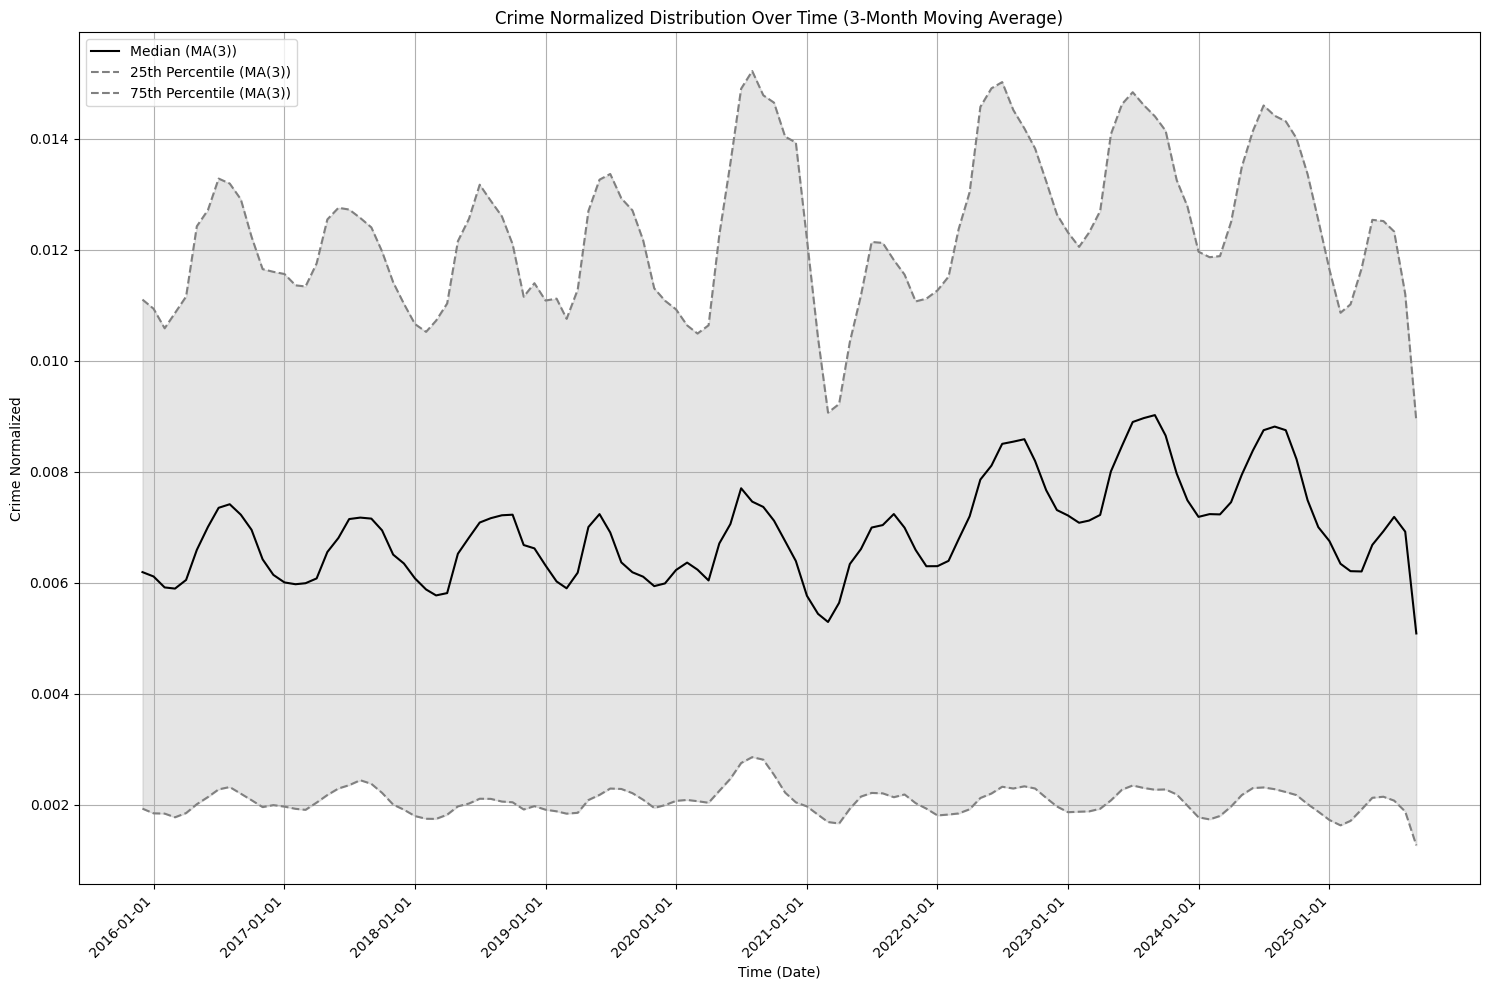

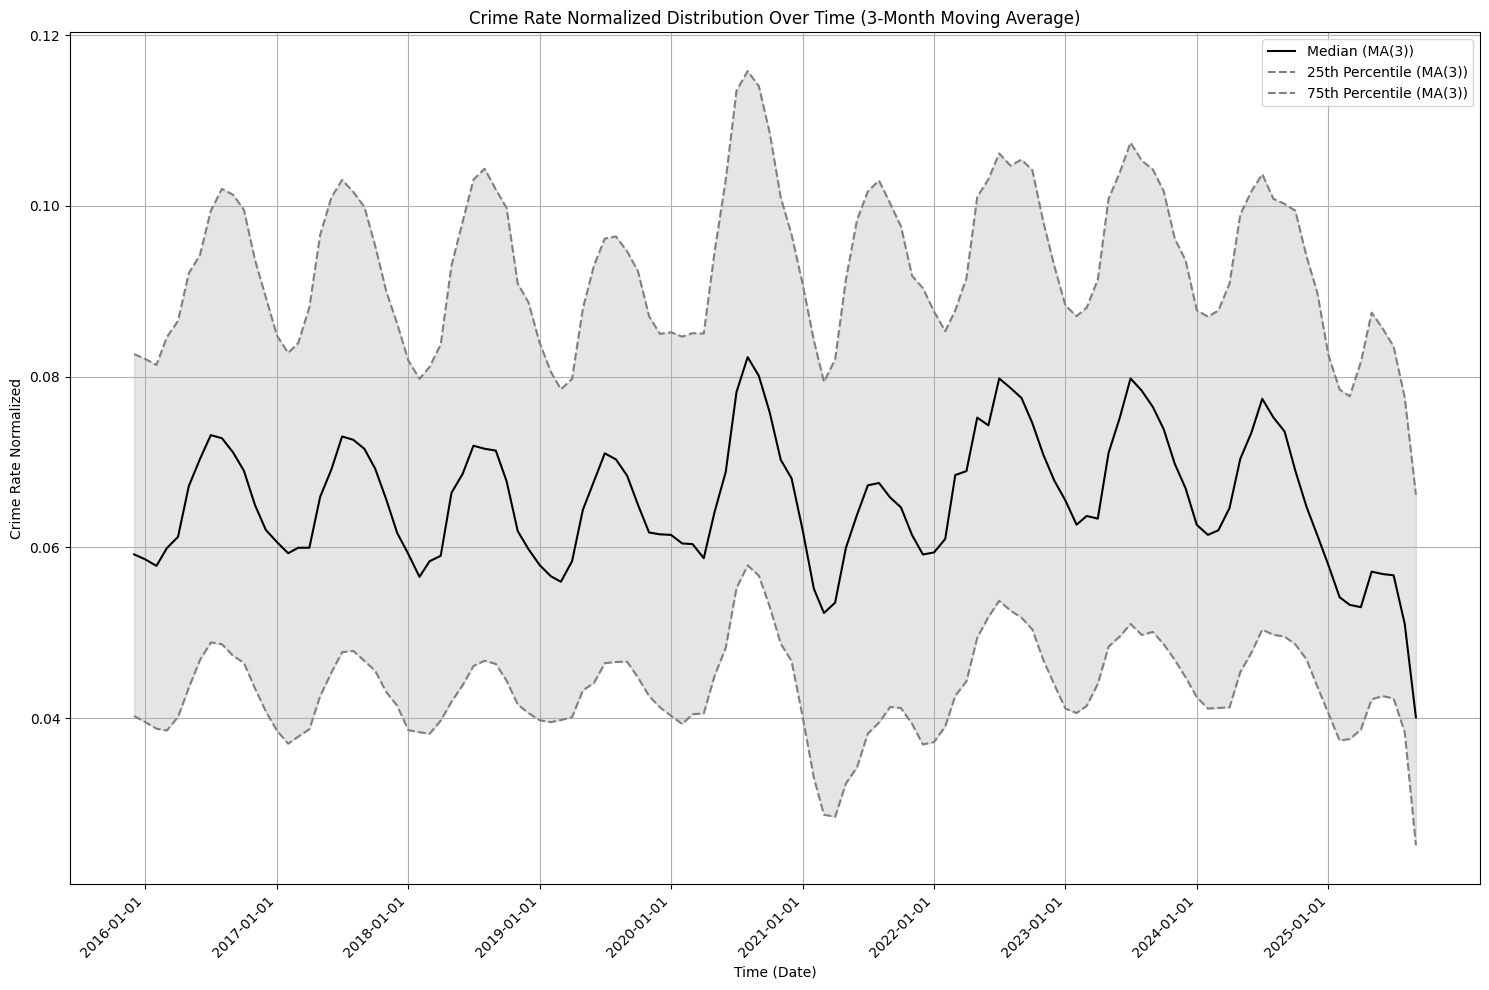

In [28]:
# ============================================================================
# STEP 4: GENERATE PLOTS SYSTEMATICALLY
# ============================================================================

# Define plot specifications
PLOT_SPECS = [
    {
        'column': 'crime_count',
        'title': 'Crime Count Distribution Over Time (3-Month Moving Average)',
        'ylabel': 'Crime Count',
        'filename': 'crime_ma3'
    },
    {
        'column': 'crime_count_weighted',
        'title': 'Crime Weighted Distribution Over Time (3-Month Moving Average)',
        'ylabel': 'Crime Weighted',
        'filename': 'crime_weighted_ma3'
    },
    {
        'column': 'crime_count_standardized',
        'title': 'Crime Standardized Distribution Over Time (3-Month Moving Average)',
        'ylabel': 'Crime Standardized',
        'filename': 'crime_standardized_ma3'
    },
    {
        'column': 'crime_rate',
        'title': 'Crime Rate Distribution Over Time (3-Month Moving Average)',
        'ylabel': 'Crime Rate',
        'filename': 'crime_rate_ma3'
    },
    {
        'column': 'crime_relative_intensity',
        'title': 'Crime Relative Intensity Distribution Over Time (3-Month Moving Average)',
        'ylabel': 'Crime Relative Intensity',
        'filename': 'crime_relative_intensity_ma3'
    },
    {
        'column': 'crime_count_normalized',
        'title': 'Crime Normalized Distribution Over Time (3-Month Moving Average)',
        'ylabel': 'Crime Normalized',
        'filename': 'crime_normalized_ma3'
    },
    {
        'column': 'crime_rate_normalized',
        'title': 'Crime Rate Normalized Distribution Over Time (3-Month Moving Average)',
        'ylabel': 'Crime Rate Normalized',
        'filename': 'crime_rate_normalized_ma3'
    }
]

# Generate all plots
for spec in PLOT_SPECS:
    plot_crime_metric(df_merged, **spec)


In [29]:
df_merged.to_csv('data/crime_pop_agg.csv', index=False)
